# Introduction 
Autoencoder is special type of deep learning architecture consisting of two networks a) encoder b)decoder. Encoder can be fully connected dense neural network or Convolution neural network. Encoder is used to downsample our original sample image into latent vector by passing image through Convolution layers and maxpool layer.Similary,decoder also can be fully connected neural network or Convolution neural network, decoder is used to upsample the latent vector downsampled by encoder. This upsampled latent vector is compared with the original input and reconstruction loss is calculated. Backpropagation is used to minimized this reconstruction loss. Simple autoencoder can be used for Domain transformation, denoising images, image colorization, anamoly detection etc. Here I am going to train my autoencoder model to generate sketch of the input image.  I donot have enough training images so my model mightnot generate very good sketch of image.

<img src = 'https://www.researchgate.net/profile/Chitralekha_Bhat/publication/317559243/figure/fig2/AS:531269123805186@1503675837486/Deep-Autoencoder-DAE.png'>

## Objective:
To convert image to sketch using autoencoder

<img src = 'https://www.seoclerk.com/pics/254019-1TRhz71407611170.jpg'>

## Import Necessary Libraries

In [1]:
import numpy as np
import tensorflow as tf
import keras 
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm 
import os
import re

## Load data
At first, I would like to thank the person who created this amazing dataset. This dataset consist of 188 image and their corresponding sketches. As these images aren't enough for training our autoencoder model, I have augmented them using open cv library. After Augmentation I have got around 1500 images, these 1500 images also might not be enough but let's give a try. These images are converted into array and are stored in the list.

In [33]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


# defining the size of image 
SIZE = 256

image_path = '../input/cuhk-face-sketch-database-cufs/photos'
img_array = []

sketch_path = '../input/cuhk-face-sketch-database-cufs/sketches'
sketch_array = []

image_file = sorted_alphanumeric(os.listdir(image_path))
sketch_file = sorted_alphanumeric(os.listdir(sketch_path))


for i in tqdm(image_file):
    image = cv2.imread(image_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    
    #appending normal normal image    
    img_array.append(img_to_array(image))
    # Image Augmentation
    
    # horizontal flip 
    img1 = cv2.flip(image,1)
    img_array.append(img_to_array(img1))
     #vertical flip 
    img2 = cv2.flip(image,-1)
    img_array.append(img_to_array(img2))
     #vertical flip 
    img3 = cv2.flip(image,-1)
    # horizontal flip
    img3 = cv2.flip(img3,1)
    img_array.append(img_to_array(img3))
    # rotate clockwise 
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    img_array.append(img_to_array(img4))
    # flip rotated image 
    img5 = cv2.flip(img4,1)
    img_array.append(img_to_array(img5))
     # rotate anti clockwise 
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img_array.append(img_to_array(img6))
    # flip rotated image 
    img7 = cv2.flip(img6,1)
    img_array.append(img_to_array(img7))
  
    
for i in tqdm(sketch_file):
    image = cv2.imread(sketch_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    # appending normal sketch image
    sketch_array.append(img_to_array(image))
    
    #Image Augmentation
    # horizontal flip 
    img1 = cv2.flip(image,1)
    sketch_array.append(img_to_array(img1))
     #vertical flip 
    img2 = cv2.flip(image,-1)
    sketch_array.append(img_to_array(img2))
     #vertical flip 
    img3 = cv2.flip(image,-1)
    # horizontal flip
    img3 = cv2.flip(img3,1)
    sketch_array.append(img_to_array(img3))
    # rotate clockwise 
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    sketch_array.append(img_to_array(img4))
    # flip rotated image 
    img5 = cv2.flip(img4,1)
    sketch_array.append(img_to_array(img5))
     # rotate anti clockwise 
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    sketch_array.append(img_to_array(img6))
    # flip rotated image 
    img7 = cv2.flip(img6,1)
    sketch_array.append(img_to_array(img7))
    
    
    
   



    

100%|██████████| 188/188 [00:00<00:00, 214.23it/s]


In [34]:
print("Total number of sketch images:",len(sketch_array))
print("Total number of images:",len(img_array))

Total number of sketch images: 1504
Total number of images: 1504


# Visualizing images
Here i have plotted all augmented images and its augmented sketches

In [43]:
# defining function to plot images pair
def plot_images(image, sketches):
    plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.title('Image', color = 'green', fontsize = 20)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.title('Sketches ', color = 'black', fontsize = 20)
    plt.imshow(sketches)
   
    plt.show()

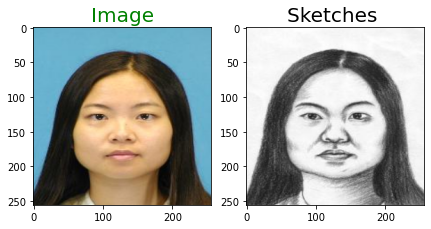

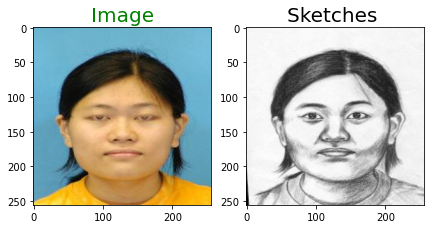

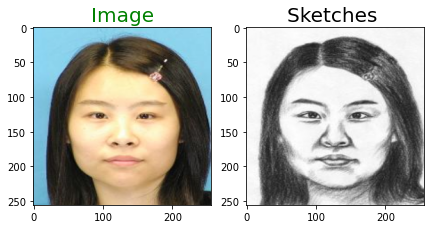

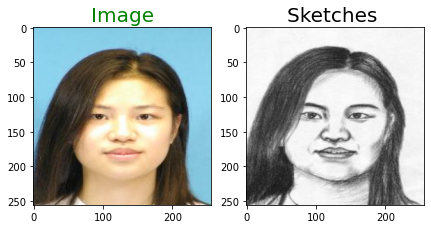

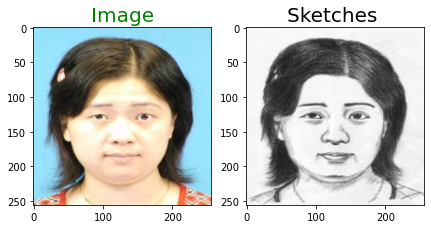

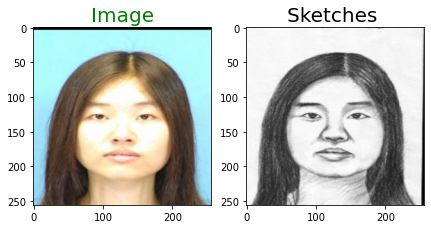

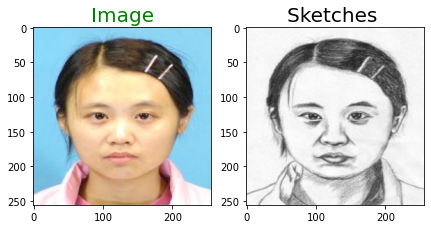

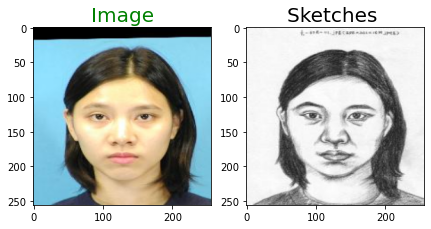

In [44]:
ls = [i for i in range(0,64,8)]
for i in ls:
    plot_images(img_array[i],sketch_array[i])



## Slicing and reshaping

Out of 1504 images I have sliced them to two part. train images consist 1400 images while test images contains 104 images. After slicing image array, I reshaped them so that images can be fed directly into our encoder network


In [45]:
train_sketch_image = sketch_array[:1400]
train_image = img_array[:1400]
test_sketch_image = sketch_array[1400:]
test_image = img_array[1400:]
# reshaping
train_sketch_image = np.reshape(train_sketch_image,(len(train_sketch_image),SIZE,SIZE,3))
train_image = np.reshape(train_image, (len(train_image),SIZE,SIZE,3))
print('Train color image shape:',train_image.shape)
test_sketch_image = np.reshape(test_sketch_image,(len(test_sketch_image),SIZE,SIZE,3))
test_image = np.reshape(test_image, (len(test_image),SIZE,SIZE,3))
print('Test color image shape',test_image.shape)

Train color image shape: (1400, 256, 256, 3)
Test color image shape (104, 256, 256, 3)


## Model
Here I have defined two blocks of networks. Encoder network takes 256 by 256 image and downsample it to 16 by 16 latent vector by passing our image via series of Convolution and Maxpooling layer. This downsampled 16 by 16 latent vector is upsampled by passing through series of Convolution and UpSampling layer. The final decoder output is same as our encoder input. This upsamples output of decoder is compared with our sketches and reconstruction loss is calculated. This loss is minimized by updating weight and bias of network through backpropagation.

In [89]:
encoder_input = keras.Input(shape=(SIZE,SIZE, 3), name="img")
x = Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', padding = 'same')(encoder_input)
x = MaxPool2D(pool_size = (2,2))(x)

x = Conv2D(filters = 32,kernel_size = (3,3),strides = (2,2), activation = 'relu', padding = 'valid')(x)
x = Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), activation = 'relu', padding = 'same')(x)
x = MaxPool2D(pool_size = (2,2))(x)

x = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = Conv2D(filters = 256 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x) 
encoder_output = Conv2D(filters = 512 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x) 
encoder = tf.keras.Model(encoder_input, encoder_output)

decoder_input = Conv2D(filters = 512 ,kernel_size = (3,3), activation = 'relu', padding = 'same')(encoder_output)
x = UpSampling2D(size = (2,2))(decoder_input)
x = Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = UpSampling2D(size = (2,2) )(x)

x = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = UpSampling2D(size = (2,2) )(x)
x = Conv2D(filters = 32 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = UpSampling2D(size = (2,2) )(x)
 
x = Conv2D(filters = 16  , kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
decoder_output = Conv2D(filters = 3, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

# final model
model = keras.Model(encoder_input, decoder_output)
model.summary()

Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_180 (Conv2D)          (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 63, 63, 32)        4640      
_________________________________________________________________
conv2d_182 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_183 (Conv2D)          (None, 16, 16, 128)     

### Compiling and Fitting our model
Here i have used Adam optimizer and mean_squared_error as loss and have trained model for 100 epochs

In [99]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(train_image, train_sketch_image, epochs = 50)

Epoch 1/50
44/44 [==============================] - 5s 116ms/step - loss: 0.0847 - acc: 0.4514
Epoch 2/50
44/44 [==============================] - 5s 115ms/step - loss: 0.0675 - acc: 0.4136
Epoch 3/50
44/44 [==============================] - 5s 113ms/step - loss: 0.0631 - acc: 0.4212
Epoch 4/50
44/44 [==============================] - 5s 112ms/step - loss: 0.0622 - acc: 0.4613
Epoch 5/50
44/44 [==============================] - 5s 117ms/step - loss: 0.0618 - acc: 0.3799
Epoch 6/50
44/44 [==============================] - 5s 111ms/step - loss: 0.0625 - acc: 0.4634
Epoch 7/50
44/44 [==============================] - 5s 113ms/step - loss: 0.0617 - acc: 0.4835
Epoch 8/50
44/44 [==============================] - 5s 112ms/step - loss: 0.0614 - acc: 0.3958
Epoch 9/50
44/44 [==============================] - 5s 112ms/step - loss: 0.0614 - acc: 0.4408
Epoch 10/50
44/44 [==============================] - 5s 113ms/step - loss: 0.0607 - acc: 0.4043
Epoch 11/50
44/44 [==============================

### Evaluating our model

In [100]:
prediction_on_test_data = model.evaluate(test_image, test_sketch_image)
print("Loss: ", prediction_on_test_data[0])
print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))

4/4 [==============================] - 0s 29ms/step - loss: 0.0794 - acc: 0.5310
Loss:  0.0794326514005661
Accuracy:  53.1


# Plotting our predicted sketch along with real sketch

In [81]:
def show_images(real,sketch, predicted):
    plt.figure(figsize = (9,9))
    plt.subplot(1,3,1)
    plt.title("Image",fontsize = 15, color = 'Lime')
    plt.imshow(real)
    plt.subplot(1,3,2)
    plt.title("sketch",fontsize = 15, color = 'Blue')
    plt.imshow(sketch)
    plt.subplot(1,3,3)
    plt.title("Predicted",fontsize = 15, color = 'gold')
    plt.imshow(predicted)

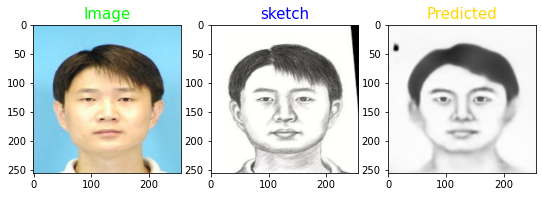

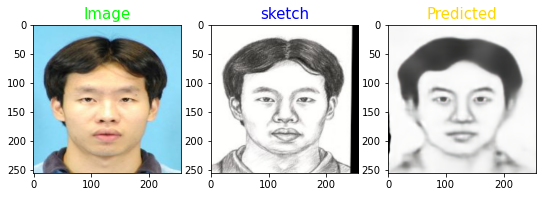

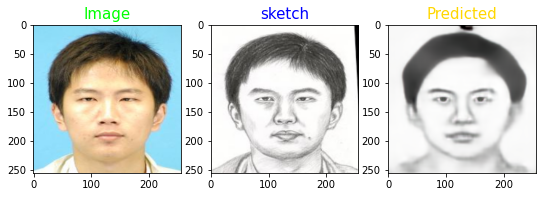

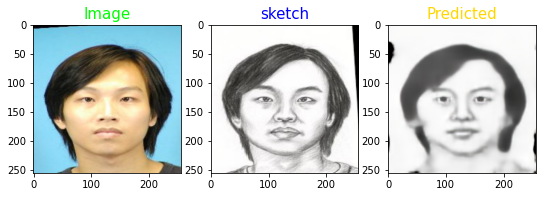

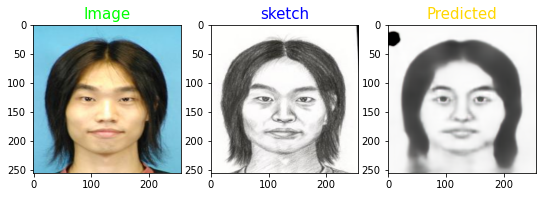

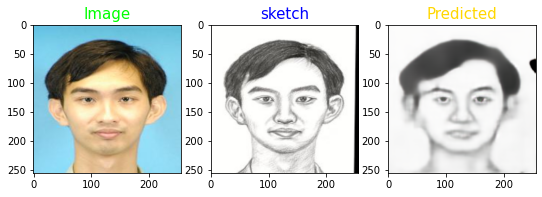

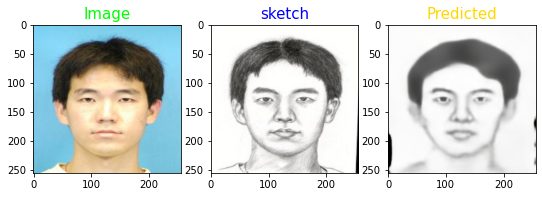

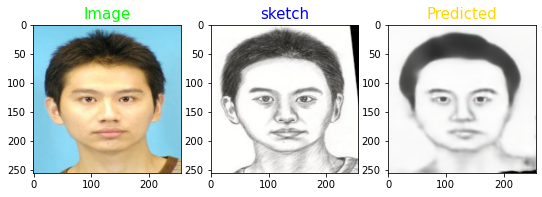

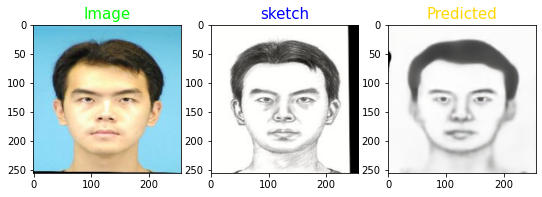

In [101]:
ls = [i for i in range(0,65,8)]
for i in ls:
    predicted =np.clip(model.predict(test_image[i].reshape(1,SIZE,SIZE,3)),0.0,1.0).reshape(SIZE,SIZE,3)
    show_images(test_image[i],test_sketch_image[i],predicted)

## Any Suggestion to Improve this model is really appreciated.
# Thanks For Your Visit